In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

sns.set_theme(style="white")

# Change matplotlib font to LaTeX-like
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
df = pd.read_pickle("../data/processed/data_one_day_clean.pickle")
df.head(5)

,Tank-ID,Zeitstempel,Füllstand,Linear Prozentwert,Sensorwert,Leerstand,Maximale Füllgrenze,Temperatur,Sensorlage,PLZ,Breitengrad,Längengrad,Sicherheitsbestand wird erreicht am,Meldebestand wird erreicht am,Verbrauch,Verbrauch smoothed
0,0,2022-10-11,3165.0,32.0,1.48,6835.0,10000.0,21.0,4.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-13.0,-5.909091
1,0,2022-10-12,3152.0,32.0,1.48,6839.0,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,0.0,-5.636364
2,0,2022-10-13,3152.0,32.0,1.48,6848.0,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-4.0,-5.454545
3,0,2022-10-14,3148.0,31.0,1.48,6848.0,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-8.0,-5.590909
4,0,2022-10-15,3140.0,31.0,1.49,6857.0,10000.0,20.0,3.0,77716.0,48.291924,8.072995,5/15/2026,6/26/2025,-3.0,-6.045455


In [4]:
def get_cleaned_data(path = "../data/processed/data_one_day_clean.pickle") -> pd.DataFrame:
    df = pd.read_pickle(path)
    # correct outliers
    df.loc[df['Verbrauch'] > 0, 'Verbrauch'] = 0.0
    # take absolute values
    df['Verbrauch'] = df['Verbrauch'].abs()
    # drop NaN values
    df = df.dropna()
    df = df[["Zeitstempel", "Verbrauch"]]

    return df

def fit_linear_model(df: pd.DataFrame, context: int = 90, degree: int = 3, forecast_days: int = 7):
    # Get newest -Days Tage
    y = df["Verbrauch"].iloc[-context:].values.reshape(-1, 1)
    X = np.arange(len(y)).reshape(-1, 1)

    # Extend feature space to make polynomial regression
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)

    # Fit linear regression with polynomial features
    lr = LinearRegression()
    lr.fit(X_poly, y)
    # Get best fitted line
    y_pred = lr.predict(X_poly)

    # Evaluate best fitted line
    r2 = r2_score(y_true=y, y_pred=y_pred)

    future_days_to_predict = np.arange(X.max(), X.max() + forecast_days).reshape(-1, 1)
    # Get prediction for future days
    future_days_extened = poly.transform(future_days_to_predict)
    y_pred_future = lr.predict(future_days_extened).flatten()

    y_train = pd.DataFrame({"Verbrauch": y.flatten()}, index=X.flatten())
    y_pred = pd.DataFrame({"Verbrauch": y_pred.flatten()}, index=X.flatten())
    y_pred_future = pd.DataFrame({"Verbrauch": y_pred_future.flatten()}, index=future_days_to_predict.flatten())

    return y_train, y_pred, y_pred_future

df = get_cleaned_data()
df

y_train, y_pred, y_pred_future = fit_linear_model(df)
y_pred_future

,Verbrauch
89,6.402748
90,6.484180
91,6.565051
92,6.645312
93,6.724912
94,6.803801
95,6.881930


# Test Area

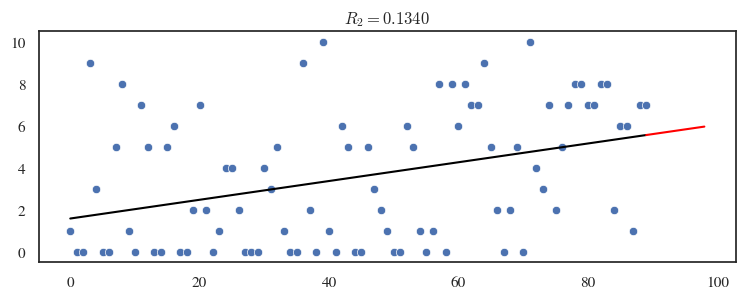

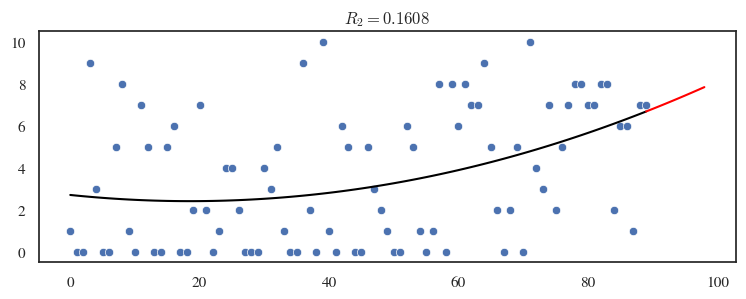

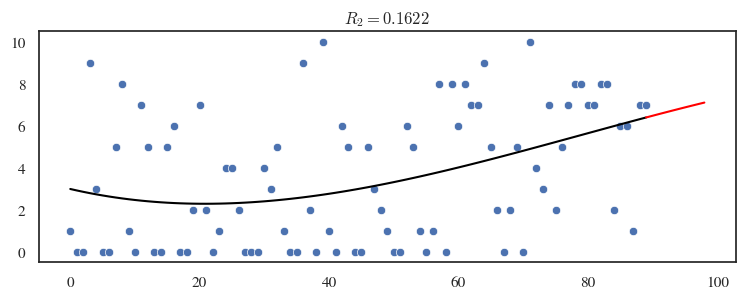

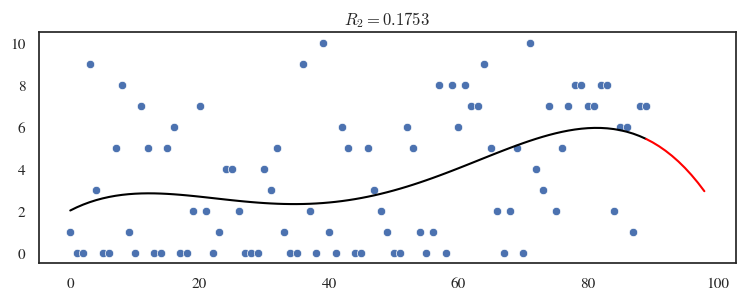

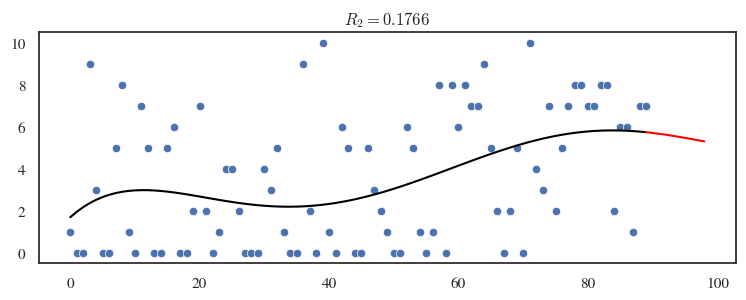

In [5]:
CONTEXT = 90
DEGREE = [1, 2, 3, 4, 5]
FORECAST_DAYS = 10

# Get newest -Days Tage
y = df["Verbrauch"].iloc[-CONTEXT:].values
X = np.arange(len(y))

FUTURE_DAYS = np.arange(X.max(), X.max() + FORECAST_DAYS).reshape(-1, 1)

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

for degree in DEGREE:
    if degree == 1:
        lr = LinearRegression()
        lr.fit(X, y)
        y_pred = lr.predict(X).flatten()
        y_pred_future = lr.predict(FUTURE_DAYS)

        r2 = r2_score(y_true=y, y_pred=y_pred)

        plt.figure(figsize=(9, 3))
        plt.title(f"$R_2 = {r2:.4f}$")
        sns.scatterplot(x=X.flatten(), y=y.flatten())
        sns.lineplot(x=X.flatten(), y=y_pred.flatten(), color="black")
        sns.lineplot(x=FUTURE_DAYS.flatten(), y=y_pred_future.flatten(), color="red")
        plt.show()
    else:
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X)
        lr = LinearRegression()
        lr.fit(X_poly, y)
        y_pred = lr.predict(X_poly)

        r2 = r2_score(y_true=y, y_pred=y_pred)

        future_days_extened = poly.transform(FUTURE_DAYS)
        y_pred_future = lr.predict(future_days_extened).flatten()

        plt.figure(figsize=(9, 3))
        plt.title(f"$R_2 = {r2:.4f}$")
        sns.scatterplot(x=X.flatten(), y=y.flatten())
        sns.lineplot(x=X.flatten(), y=y_pred.flatten(), color="black")
        sns.lineplot(x=FUTURE_DAYS.flatten(), y=y_pred_future.flatten(), color="red")
        plt.show()
